*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


In [2]:
import pickle
import numpy as np
from gensim.models import KeyedVectors

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Sentence similarity

In lecture, we demonstrated how word embeddings can be used to compute the similarity between two words. This idea extends naturally to **sentence similarity** as well.

To get started, use the following code to tokenize a sentence into words. (We will explore more advanced tokenization methods—like subword tokenizers—when we cover Transformers in detail.)

In [3]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # Apparently needed to avoid errors downstream

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text.lower())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\spher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


To compute a sentence embedding, we take the **average (mean)** of the embeddings of all words in the sentence.

For both the query sentence and each sentence in the list defined below: 

- Compute the average of the word embeddings to obtain the sentence embedding. 
- Compute and print the **cosine similarity** of the query sentence against each of the sentences in the list. 
- Compare how sentence-level meaning is captured across different embedding sources.



In [4]:
# List of sentences for comparison
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

In [5]:
# Load Pytorch skip-gram embeddings
with open('word2vec_embeddings.pkl', 'rb') as f:
    pytorch_skipgram = pickle.load(f)

pytorch_embeddings = pytorch_skipgram['embeddings']
pytorch_word2idx = pytorch_skipgram['word2idx']
pytorch_idx2word = pytorch_skipgram['idx2word']

# Load Gensim Word2Vec (Text8)
with open('word2vec_gensim_embeddings.pkl', 'rb') as f:
    w2v_text8 = pickle.load(f)

w2v_text8_embeddings = w2v_text8['embeddings']
w2v_text8_word2idx = w2v_text8['word2idx']
w2v_text8_idx2word = w2v_text8['idx2word']

# Load pretrained Gensim Word2Vec (Google)
w2v_google = KeyedVectors.load('word2vec-google-news-300.model', mmap='r')

# Load pretrained Gensim FastText
fasttext = KeyedVectors.load('fasttext-wiki-news-subwords-300.model', mmap='r')

In [6]:
# Write lookup functions to get embedding for given word
def get_pytorch_vec(word):
    if word in pytorch_word2idx:
        return pytorch_embeddings[pytorch_word2idx[word]]
    else:
        return None
    
def get_w2v_text8_vec(word):
    if word in w2v_text8_word2idx:
        return w2v_text8_embeddings[w2v_text8_word2idx[word]]
    else:
        return None
    
def get_w2v_google_vec(word):
    if word in w2v_google:
        return w2v_google[word]
    else:
        return None
    
def get_fasttext_vec(word):
    return fasttext[word]   # FastText can handle OOV words b/c it includes subword info

In [7]:
# General function to compute sentence embedding
def get_sentence_embedding(sentence, get_vec_func, embedding_dim):
    # Tokenize sentence (inputted as string)
    tokens = tokenize_text(sentence)

    # Get word vectors using the inputted get_vec_func function
    word_vecs = []
    for token in tokens:
        vec = get_vec_func(token)
        if vec is not None:
            word_vecs.append(vec)

    # Handle case of empty sentence
    if len(word_vecs) == 0:
        return np.zeros(embedding_dim)
    
    # Return mean of word vecs to get sentence embedding
    return np.mean(word_vecs, axis=0)

In [8]:
# Compute sentence embeddings from average of word embeddings
query_embed_pytorch = get_sentence_embedding(query, get_pytorch_vec, 100)
sentence_embeds_pytorch = [get_sentence_embedding(s, get_pytorch_vec, 100) for s in sentences]

query_embed_w2v_text8 = get_sentence_embedding(query, get_w2v_text8_vec, 100)
sentence_embeds_w2v_text8 = [get_sentence_embedding(s, get_w2v_text8_vec, 100) for s in sentences]

query_embed_w2v_google = get_sentence_embedding(query, get_w2v_google_vec, 300)
sentence_embeds_w2v_google = [get_sentence_embedding(s, get_w2v_google_vec, 300) for s in sentences]

query_embed_fasttext = get_sentence_embedding(query, get_fasttext_vec, 300)
sentence_embeds_fasttext = [get_sentence_embedding(s, get_fasttext_vec, 300) for s in sentences]

In [9]:
# Compute and print cosine similarities of query sentence w/ each sentence in list

# Create function to calculate cosine similarities
def get_cosine_sims(query_embed, sentence_embeds):
    sims = cosine_similarity(query_embed.reshape(1,-1), np.vstack(sentence_embeds))[0]
    return sims

# Print cosine similarities as dataframe
df = {
    'Sentence': sentences, 
    'PyTorch Skip-Gram': get_cosine_sims(query_embed_pytorch, sentence_embeds_pytorch),
    'Gensim Word2Vec': get_cosine_sims(query_embed_w2v_text8, sentence_embeds_w2v_text8),
    'Gensim Word2Vec (Google)': get_cosine_sims(query_embed_w2v_google, sentence_embeds_w2v_google),
    'Gensim FastText': get_cosine_sims(query_embed_fasttext, sentence_embeds_fasttext),
    }

df = pd.DataFrame.from_dict(df)
df.style.background_gradient(subset=df.columns[1:], cmap='viridis')

,Sentence,PyTorch Skip-Gram,Gensim Word2Vec,Gensim Word2Vec (Google),Gensim FastText
0,The cat sat on the mat.,0.660781,0.703903,0.736872,0.911408
1,A dog is playing in the yard.,0.546861,0.596961,0.648278,0.851180
2,I need to buy groceries today.,0.388509,0.194194,0.371789,0.585846
3,The feline was resting on the rug.,0.467429,0.493993,0.779382,0.924730
4,Canines enjoy outdoor activities.,0.275424,0.072648,0.428147,0.650420
5,My shopping list includes milk and bread.,0.528761,0.460364,0.496959,0.834956
6,The weather is beautiful today.,0.438396,0.486443,0.431013,0.809037
7,Programming requires logical thinking.,0.250567,0.084597,0.297923,0.613466


<font color="red"> 

First, the PyTorch Skip-gram embeddings seem to be relatively weak at capturing sentence-level meaning. Although it correctly ranks the sentence with "cat" and "mat" as one of the most similar sentences to the query, it does not seem to capture the synonymy of "cat"/"feline", "sleeping"/"resting", and "carpet"/"mat"/"rug", nor does it seem to clearly understand that "cat"/"feline" and "dog"/"canines" are relatively related as both being animals (i.e. it does not generalize well to broader semantic categories). It also overestimates the similarity of shopping-related sentences. This could be because of a lower embedding dimensionality and Text8 being a relatively small corpus, and thus weaker co-occurrence statistics.

Next, the Gensim Word2Vec (Text8) embeddings perform marginally better than the PyTorch Skip-gram embeddings, but they still struggle with the same issues for similar reasons. The slightly better performance might be due to, say, better hyperparameters and other differences in implementation rather than a fundamental difference in methodology.

In contrast, the pretrained Gensim Word2Vec (Google News) embeddings perform noticeably better than both of the previous embedding sources. These embeddings capture the synonymy of "cat"/"feline", "sleeping"/"resting", and "carpet"/"mat"/"rug" much better as the two sentences containing those terms have substantially higher cosine similarities to the query sentence than the other sentences. The shopping-related sentences have cosine similarities that are more distinctly lower than the cat=related sentences, showing better semantic separation. These improvements might be due to the significantly larger and more diverse corpus and the higher embedding dimensionality, making the model better at capturing more complex patterns and longer-range co-occurrences.

Lastly, the pretrained FastText embeddings appear to perform marginally worse than the pretrained Gensim Word2Vec (Google News) embeddings. It also captures synonymy where it is expected for the cat/sleeping/carpet-related terms, ranking sentences containing those terms as the highest. However, it performs worse than the pretrained Gensim Word2Vec at distinguishing the shopping list and weather-related sentences from those cat-related sentences. This is likely because FastText relies on subword information, which means that words are considered similar more so in a morphological sense than a semantic sense. Although this would be useful in cases with OOV issues (rare words, typos) and cases involving word-level semantics, it means that FastText is not the best-suited for capturing semantic similarity and semantic separation at the sentence-level. 

</font>

## Embedding visualization

Use **t-SNE** and **UMAP** to visualize and compare how different embedding sources cluster semantically related words. Specifically, plot the embeddings of the following two semantic categories:

- Color code each category (e.g., animals in blue, foods in orange)
- Run visualizations for **all four embedding types**:
  - PyTorch-trained
  - Gensim-trained
  - Pretrained Word2Vec
  - Pretrained FastText
- Observe whether words from the same category cluster together, and whether the separation between categories is consistent across embeddings.

In [10]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

In [11]:
# Write function to organize embeddings for a group of words
def organize_embeddings(words, category_name, get_vec_func):
    word_vecs = []      # Embedding for a word
    word_labels = []    # Indicate what word the embedding belongs to
    categories = []

    for word in words:
        word_vec = get_vec_func(word)
        if word_vec is not None:
            word_vecs.append(word_vec)
            word_labels.append(word)
            categories.append(category_name)
    
    return word_vecs, word_labels, categories

# Write function to create embeddings dataset for an embedding source
def build_embedding_dataset(get_vec_func):
    animal_vecs, animal_labels, animal_categories = organize_embeddings(animals, "animal", get_vec_func)
    food_vecs, food_labels, food_categories = organize_embeddings(foods, "food", get_vec_func)

    X = np.vstack(animal_vecs + food_vecs)
    labels = animal_labels + food_labels
    categories = animal_categories + food_categories

    return X, labels, categories

# Write function to run t-SNE
def run_tsne(X, n_components=2, perplexity=5.0, init='pca', early_exaggeration=12.0, learning_rate='auto', random_state=42):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        init=init,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=random_state
    )
    return tsne.fit_transform(X)

# Write function to run UMAP
def run_umap(X, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42):
    umap = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    return umap.fit_transform(X)

# Write function to create annotated scatterplot given reduced X, labels, categories, title
def plot_embeddings(X_2d, labels, categories, title):
    plt.figure(figsize=(7,4))

    for category, color in [('animal', 'blue'), ('food', 'orange')]:
        idxs = [i for i,c in enumerate(categories) if c==category]
        plt.scatter(X_2d[idxs,0], X_2d[idxs,1], label=category, color=color)

        for i in idxs:
            plt.annotate(labels[i], (X_2d[i,0], X_2d[i,1]), fontsize=9)

    plt.legend()
    plt.title(title)
    plt.show()

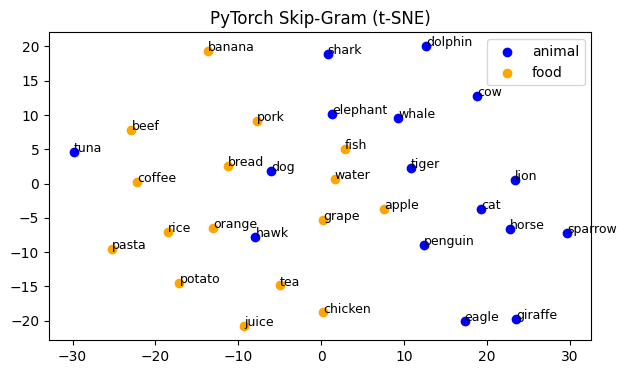

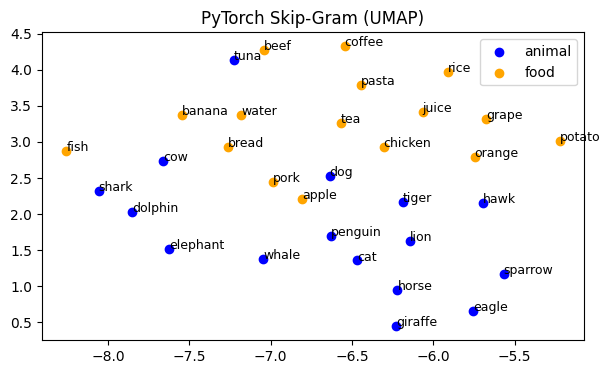

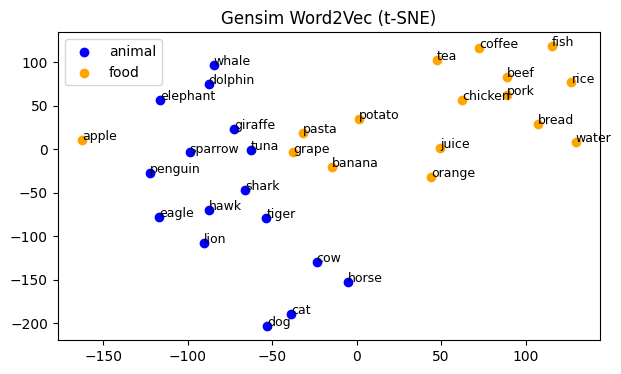

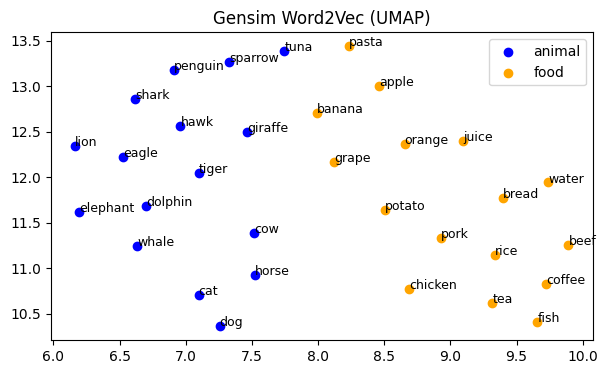

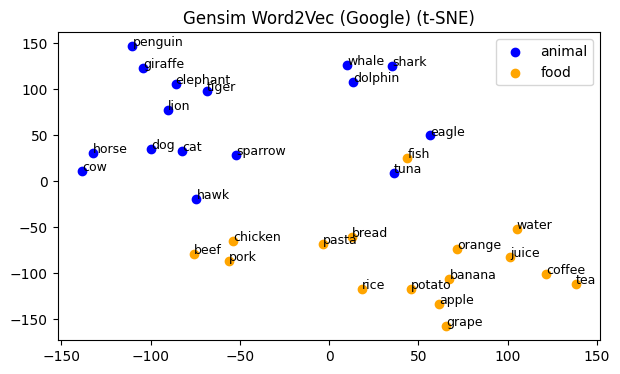

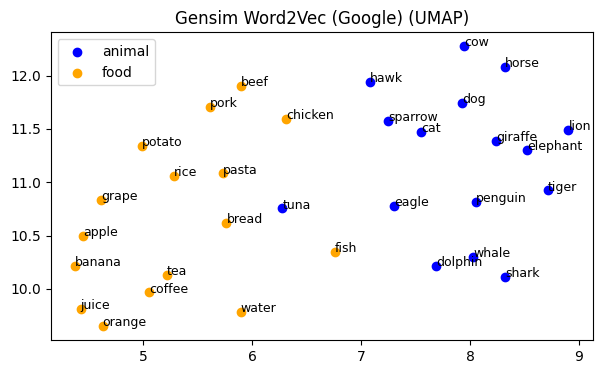

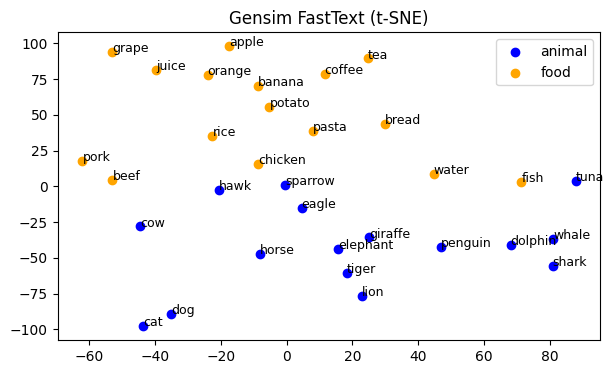

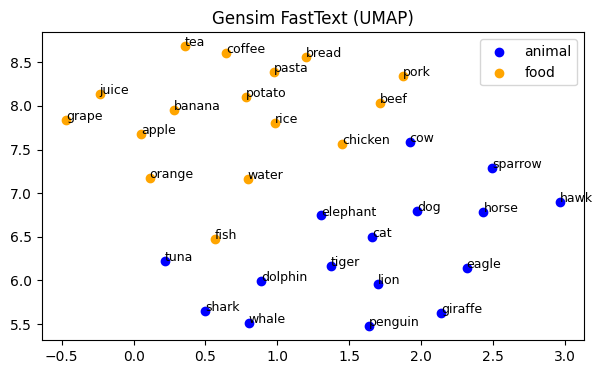

In [12]:
# Run visualizations for all 4 embedding sources
embedding_lookups = {
    'PyTorch Skip-Gram': get_pytorch_vec,
    'Gensim Word2Vec': get_w2v_text8_vec,
    'Gensim Word2Vec (Google)': get_w2v_google_vec,
    'Gensim FastText': get_fasttext_vec,
}

for source, lookup_fn in embedding_lookups.items():
    X, labels, categories = build_embedding_dataset(lookup_fn)

    X_tsne = run_tsne(X)
    plot_embeddings(X_tsne, labels, categories, f'{source} (t-SNE)')

    X_umap = run_umap(X)
    plot_embeddings(X_umap, labels, categories, f'{source} (UMAP)')

<font color="red"> 

For all 4 embedding types, both t-SNE and UMAP yielded visualizations that show words from the same categories clustering together. However, the separation between categories varies somewhat across embedding types. The Pytorch Skip-gram embeddings yielded the least clear separations, and the three other embedding types yielded roughly equally clear separations. The shape of the separations varies between each embedding type and also between t-SNE versus UMAP. Using only the default hyperparameters for both t-SNE and UMAP, UMAP seems to be marginally better than t-SNE at creating distinct clusters. The best combination of embedding type and dimensionality reduction method is Gensim Word2Vec on Text8 using UMAP. 

</font>

## Short Answer Questions

After completing the previous tasks, answer the following questions in a short written response in the `inspect_embeddings.ipynb` file:

- Which embeddings performed best at capturing sentence meaning?
- Were the pretrained embeddings significantly better than your own? Why or why not?
- What factors might explain the differences in performance?


<font color="red"> 

I think the pretrained Word2Vec embeddings based on the Google News corpus performed the best at capturing sentence-level semantics. This is most evident in how well they were able to clearly distinguish sentences semantically similar to the query sentence from others. In other words, it yielded the most interpretable cosine similarities and demonstrated the best understanding of what makes some sentences semantically similar and others dissimilar.

The pretrained embeddings were significantly better than my Pytorch Skip-gram embeddings. This is likely because of how the pretrained embeddings were trained on significantly larger and more diverse corpuses, as well as having greater embedding dimensionality, allowing the models to better capture distributional patterns. In other words, they were able to learn stronger co-occurrence statistics.

Factors that can explain the differences in performance include the scale of the training data, the diversity of the training data, the embedding dimensionality, the training hyperparameters, and whether or not the models used subword information. Also, for the case of FastText which is better for word-level semantics due to its use of subword information, the averaging of word embeddings to get a sentence embedding could also be a factor affecting performance as it contributes to inflated cosine similarities. This is because of how using subwords increases the similarity of semantically-unrelated words simply by sharing morphological features (e.g. "running" and "sleeping" both have "-ing" despite being semantically very different), ultimately inflating cosine similarity at the sentence-level.
</font>

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

<font color="red">I used ChatGPT and Codex for concept explanations (e.g. what moving things to a device means, clarification on how negative sampling works, understanding the differences between the embedding sources, etc.) and coding guidance/suggestions for using Pytorch and handling pickle/model files. I also used ChatGPT for help with setting up Google Colab and for drafting code for the visualizations. I verified things myself by reading documentation, reviewing outputs, and reviewing my code line-by-line to make sure I understand what is happening.</font>
